In [1]:
%load_ext autoreload
%autoreload 2

# Notebook: Models

In [2]:
import matplotlib.pyplot as plt
import seaborn as sbn

sbn.set()

## Load the dataset

In [3]:
from ceruleo.dataset.catalog.PHMDataset2018 import PHMDataset2018, FailureType

2022-08-09 16:42:17.021074: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-09 16:42:17.023657: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-09 16:42:17.023665: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
dataset = PHMDataset2018(
    tools=['01_M01', '04_M01']
)

### Create a transformer for a dataset

In [65]:
from ceruleo.dataset.analysis.numerical_features import analysis
from ceruleo.transformation.functional.transformers import Transformer
from ceruleo.transformation.features.selection import ByNameFeatureSelector, ByTypeFeatureSelector
from ceruleo.iterators.iterators import RelativeToEnd
from ceruleo.transformation.features.slicing import SliceRows
from ceruleo.transformation.functional.pipeline.pipeline import make_pipeline
from ceruleo.transformation.features.resamplers import IndexMeanResampler
from ceruleo.transformation.features.transformation import Clip
from ceruleo.transformation.features.slicing import SliceRows
from ceruleo.iterators.iterators import RelativeToEnd
from ceruleo.transformation.features.scalers import MinMaxScaler

In [67]:
FEATURES = [
   'IONGAUGEPRESSURE', 'ETCHBEAMVOLTAGE', 'ETCHBEAMCURRENT',
   'ETCHSUPPRESSORVOLTAGE', 'ETCHSUPPRESSORCURRENT', 'FLOWCOOLFLOWRATE',
   'FLOWCOOLPRESSURE', 'ETCHGASCHANNEL1READBACK', 'ETCHPBNGASREADBACK',
]
transformer = Transformer(
    pipelineX=make_pipeline(
        ByNameFeatureSelector(features=FEATURES), 
        IndexMeanResampler(rule='120s'),
        SliceRows(initial=RelativeToEnd(1500)),
        MinMaxScaler(range=(-1, 1))

    ), 
    pipelineY=make_pipeline(
        ByNameFeatureSelector(features=['RUL']),  
        IndexMeanResampler(rule='120s'),
        SliceRows(initial=RelativeToEnd(1500)),
        MinMaxScaler(range=(-1, 1))
    )
)



## Split train-test-validation

In [68]:
from sklearn.model_selection import train_test_split

In [69]:
train_dataset, test_dataset = train_test_split(dataset, train_size=0.8)

In [70]:
train_dataset, val_dataset = train_test_split(train_dataset, train_size=0.8)

In [71]:
len(train_dataset), len(val_dataset), len(test_dataset)

(13, 4, 5)

## Create iterators

# Models

## Scikit-learn

In [72]:
import sklearn.pipeline as sk_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from ceruleo.models.sklearn import EstimatorWrapper, TimeSeriesWindowTransformer, CeruleoRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

In [73]:

regressor = CeruleoRegressor(
    TimeSeriesWindowTransformer(
        transformer,
        window_size=15,
        step=8),   
    RandomForestRegressor())

regressor.fit(train_dataset)

/home/luciano/fuentes/ceruleo/ceruleo/models/sklearn.py:41: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y, **fit_params)


CeruleoRegressor(memory=None,
                 steps=[('timeserieswindowtransformer',
                         TimeSeriesWindowTransformer(step=8,
                                                     transformer=<ceruleo.transformation.functional.transformers.Transformer object at 0x7f10d281c0d0>,
                                                     window_size=15)),
                        ('estimatorwrapper',
                         EstimatorWrapper(estimator=RandomForestRegressor()))],
                 verbose=False)

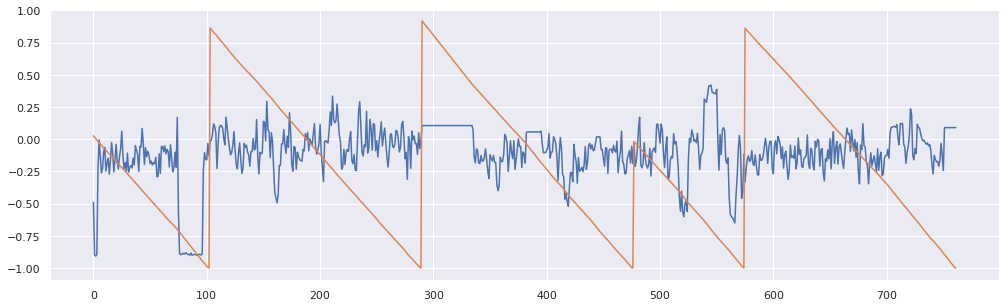

In [74]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(regressor.predict(test_dataset))
ax.plot(regressor.features_transformer.true_values(test_dataset))

## Parameters grid search


In [75]:
regressor.get_params()

{'memory': None,
 'steps': [('timeserieswindowtransformer',
   TimeSeriesWindowTransformer(step=8,
                               transformer=<ceruleo.transformation.functional.transformers.Transformer object at 0x7f10d281c0d0>,
                               window_size=15)),
  ('estimatorwrapper', EstimatorWrapper(estimator=RandomForestRegressor()))],
 'verbose': False,
 'timeserieswindowtransformer': TimeSeriesWindowTransformer(step=8,
                             transformer=<ceruleo.transformation.functional.transformers.Transformer object at 0x7f10d281c0d0>,
                             window_size=15),
 'estimatorwrapper': EstimatorWrapper(estimator=RandomForestRegressor()),
 'timeserieswindowtransformer__output_size': 1,
 'timeserieswindowtransformer__right_closed': True,
 'timeserieswindowtransformer__sample_weight': <ceruleo.iterators.sample_weight.NotWeighted at 0x7f11845fb010>,
 'timeserieswindowtransformer__shuffler': <ceruleo.iterators.shufflers.NotShuffled at 0x7f11845fb

In [76]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=regressor,
             param_grid={
                 'timeserieswindowtransformer__window_size': [20, 40, 80, 160], 
            }
)
grid_search.fit(dataset)

TypeError: CeruleoRegressor.__init__() missing 2 required positional arguments: 'features_transformer' and 'regressor'

## Tensorflow // Keras

### Build tf.Data iterators

In [54]:
from ceruleo.iterators.utils import true_values
from ceruleo.iterators.shufflers import AllShuffled
from ceruleo.iterators.iterators import WindowedDatasetIterator
from ceruleo.models.keras.dataset import tf_regression_dataset
import tensorflow as tf

#### Fit the transformer

In [55]:
transformer.fit(train_dataset)

#### Build the WindowedDatasetIterator

In [56]:
train_iterator = WindowedDatasetIterator(
    train_dataset.map(transformer),
    window_size=150,
    step=1,
    horizon=1,
    shuffler=AllShuffled())

val_iterator = WindowedDatasetIterator(
    val_dataset.map(transformer),
    window_size=150,
    step=1,
    horizon=1)

test_iterator = WindowedDatasetIterator(
    val_dataset.map(transformer),
    window_size=150,
    step=1,
    horizon=1)

### Build tensorflow model

In [61]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, MaxPooling1D,  Flatten, Dense

input = Input(train_iterator.shape)
x = Conv1D(64, 3, activation='relu')(input)
x = MaxPooling1D(2)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='relu')(x)

model = Model(input, x)
model.compile(loss='mae', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              weighted_metrics=[])

In [62]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 150, 9)]          0         
                                                                 
 conv1d_21 (Conv1D)          (None, 148, 64)           1792      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 74, 64)           0         
 )                                                               
                                                                 
 conv1d_22 (Conv1D)          (None, 72, 64)            12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 36, 64)           0         
 1D)                                                             
                                                                 
 conv1d_23 (Conv1D)          (None, 34, 64)            1235

In [63]:

model.fit(tf_regression_dataset(train_iterator).batch(8),
         validation_data=tf_regression_dataset(val_iterator).batch(8),
         
         epochs=50)

Epoch 1/50
1778/1778 [==============================] - 11s 6ms/step - loss: 16223.5762 - val_loss: 9202.7344
Epoch 2/50
1778/1778 [==============================] - 11s 6ms/step - loss: 9746.3232 - val_loss: 9179.7070
Epoch 3/50
1778/1778 [==============================] - 12s 7ms/step - loss: 9451.9766 - val_loss: 9074.7822
Epoch 4/50
1778/1778 [==============================] - 13s 7ms/step - loss: 9260.9521 - val_loss: 8964.1523
Epoch 5/50
1778/1778 [==============================] - 13s 7ms/step - loss: 9123.2363 - val_loss: 8825.9990
Epoch 6/50
1778/1778 [==============================] - 13s 7ms/step - loss: 8998.9639 - val_loss: 8892.0957
Epoch 7/50
1778/1778 [==============================] - 14s 8ms/step - loss: 8919.1719 - val_loss: 8993.0078
Epoch 8/50
1778/1778 [==============================] - 14s 8ms/step - loss: 8875.1396 - val_loss: 9066.6748
Epoch 9/50
 468/1778 [======>.......................] - ETA: 10s - loss: 8814.5830

KeyboardInterrupt: 

128/128 [==============================] - 2s 16ms/step


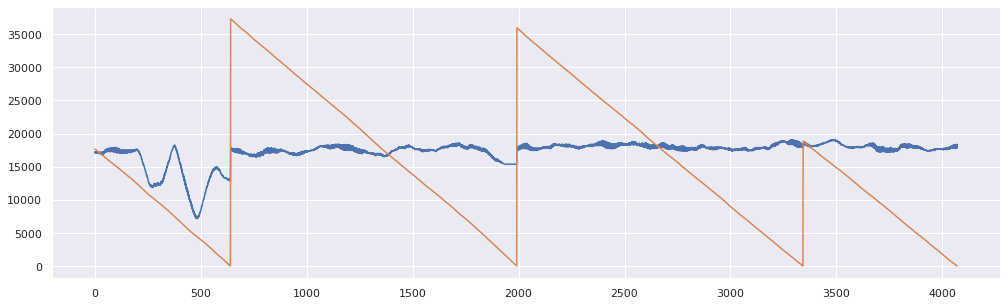

In [64]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(model.predict(tf_regression_dataset(test_iterator).batch(32)))
ax.plot(true_values(test_iterator))

### Catalog

## Pytorch